# Stock Prediction using ARIMA Model
This project showcases performance of ARIMA model for stock prediction on Microsoft share data.
There are different parameters on which model can be trained and used for making prediction.
<ol>
<li>Open</li>
<li>High</li>
<li>Low</li>
<li>Close</li>
<li>Volume</li>
</ol>
This project is using Close price for stock prediction

## ARIMA Model
ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

We need to determine following three coeffiecients to train AIMA model.
<ol>
<li>p is the order of the AR term</li>
<li>q is the order of the MA term</li>
<li>d is the number of differencing required to make the time series stationary</li>
</ol>


In [2]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import math
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
from math import sqrt
from matplotlib import pyplot
from datetime import timedelta

In [3]:
msft = yf.Ticker("MSFT")

In [4]:
#Fetching 3 years of data from yfinance

df = msft.history(start="2018-05-11", end="2021-05-10")

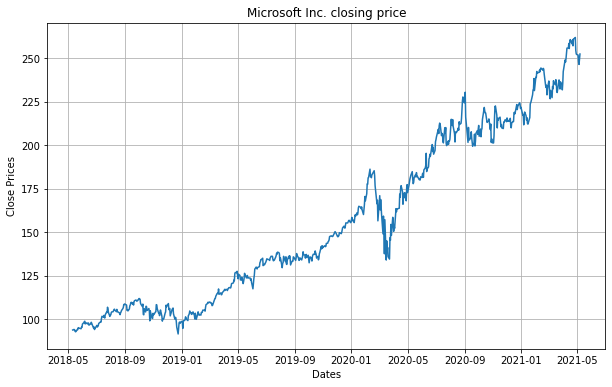

In [5]:
#Value graph plot for MSFT closing price

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df.Close)
plt.title('Microsoft Inc. closing price')
plt.show()

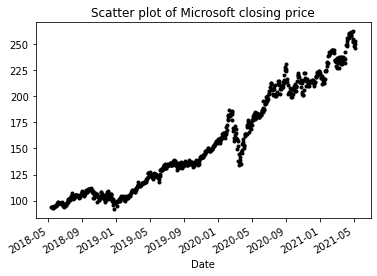

In [6]:
# Scatter Plot
df_close = df.Close
df_close.plot(style='k.')
plt.title('Scatter plot of Microsoft closing price')
plt.show()

### ADF TEST for Stationarity Check
The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

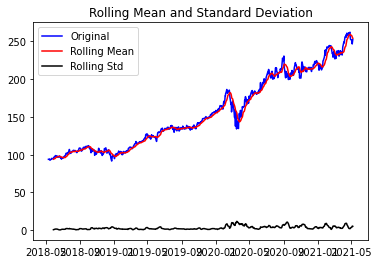

Results of dickey fuller test
Test Statistics                  0.296870
p-value                          0.977200
No. of lags used                13.000000
Number of observations used    739.000000
critical value (1%)             -3.439230
critical value (5%)             -2.865459
critical value (10%)            -2.568857
dtype: float64


In [7]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close.dropna())

####  Separate Trend and Seasonality from the time series.


<Figure size 432x288 with 0 Axes>

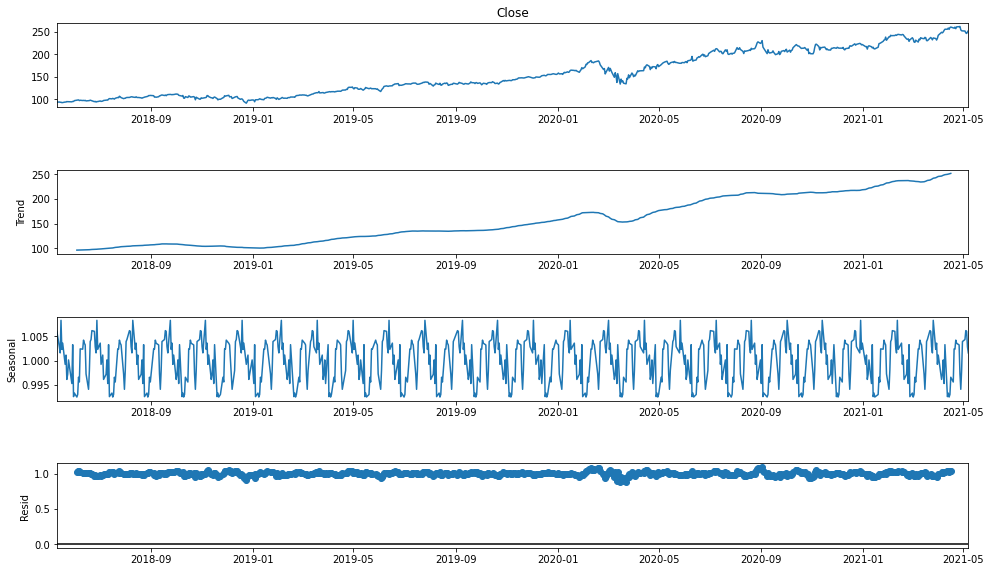

In [8]:
result = seasonal_decompose(df.Close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

#### Rolling Mean & Standard Deviation

Reduce the rising trend in the series

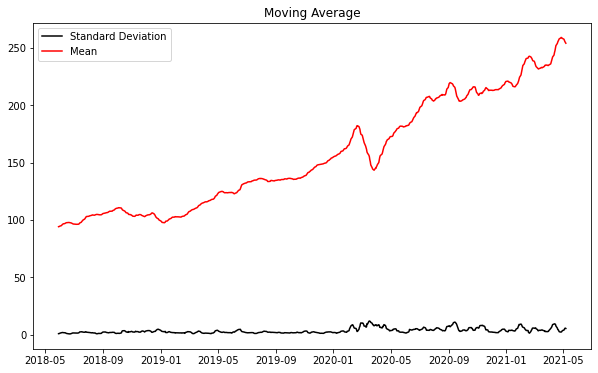

In [9]:
rcParams['figure.figsize'] = 10, 6
df_log = df_close
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

### Creating ARIMA model
#### split data into train and training set

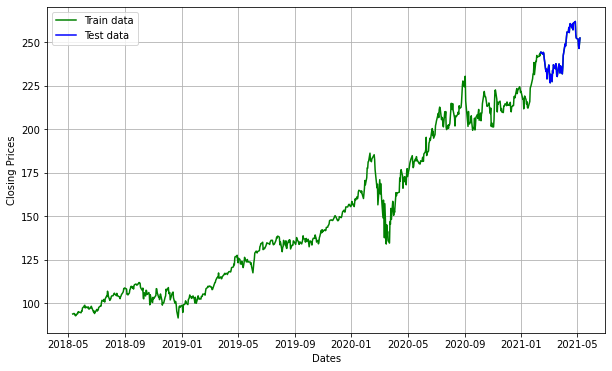

In [10]:
size = int(len(df.Close))-60
train_data, test_data = df.Close[0:size], df.Close[size:len(df.Close)]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

### Using Auto-ARIMA to determine the values of p,d,q

In [11]:
model_autoARIMA = pm.auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3581.084, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3518.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3527.329, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3582.169, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3520.260, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3520.397, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3521.780, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3522.416, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.444 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  693
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1756.367
Date:                Tue, 11 May 2021   AIC                           3518.734
Time:                        09:40:3

#### Residual plots from auto ARIMA.

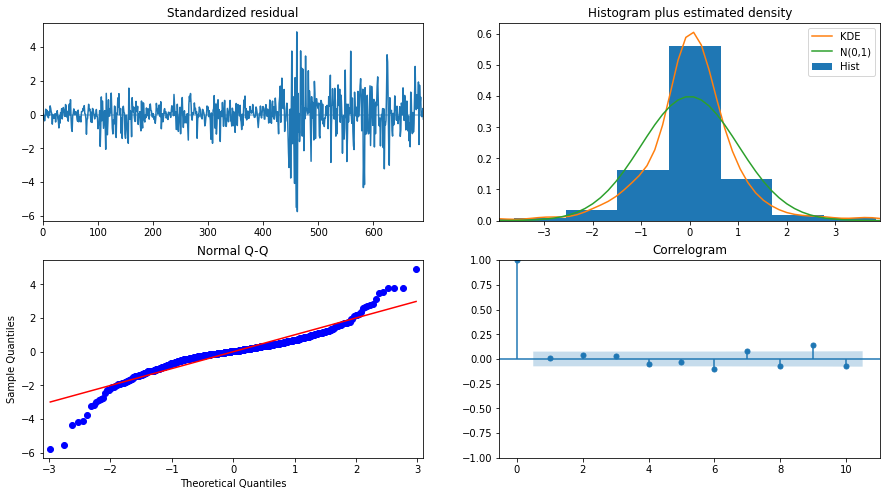

In [12]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [13]:
#Suggestion function
def what_to_do(historical_ohlc_avg, next_day_prediction):
    mean_of_historical_ohlc_avg = historical_ohlc_avg.mean()
    if next_day_prediction > mean_of_historical_ohlc_avg:
        return 'buy'
    elif next_day_prediction < mean_of_historical_ohlc_avg:
        return 'sell'
    else:
        return 'hold'

### Passing p,d, q values to normal ARIMA

In [14]:
size = int(len(df.Close))-60
train, test = df.Close[0:size], df.Close[size:len(df.Close)]
history = [x for x in train]
predictions = list()
correct = wrong = total = 0
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    prediction = what_to_do(df.Close[len(df.Close[0:size])+t-60:len(df.Close[0:size])+t],yhat)
    print('Prediction: Tomorrow (utc:{}) it is more favourable to {}'.format(str(test.index[t-60].date()), prediction))
    real = what_to_do(df.Close[len(df.Close[0:size]) + t - 60:len(df.Close[0:size]) + t], test[t-60])
    print(real)
    if prediction != real:
        wrong += 1
    else:
        correct += 1
    total += 1
print("Correct predictions:", correct)
print("Wrong predictions:", wrong)

series = pd.Series(predictions,index=test.index)
error = mean_squared_error(test, predictions)
print(error)

Prediction: Tomorrow (utc:2021-02-11) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-12) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-16) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-17) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-18) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-19) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-22) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-23) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-24) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-25) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-26) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-03-01) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-03-02) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-03-03) it is more favourable to buy
buy
Predic

#### Graph plot and RMSE calculation

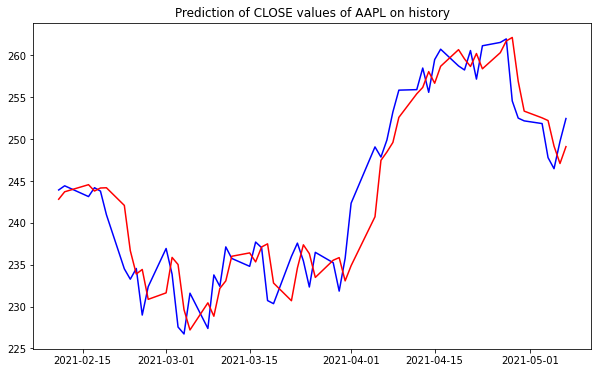

MSE: 12.616239312103204
MAE: 2.8660721156366504
RMSE: 3.5519345872500527
R-squared score:  0.8902714359041635


In [15]:
pyplot.figure(figsize=(10,6))
pyplot.title("Prediction of CLOSE values of AAPL on history")
pyplot.plot(test,color='blue')
pyplot.plot(series ,color='red')
pyplot.savefig("ARIMA ")
pyplot.show()



mse = mean_squared_error(test, series)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, series)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, series))
print('RMSE: '+str(rmse))
r2 = r2_score(test, series, sample_weight=None, multioutput='uniform_average')
print('R-squared score: ', r2)

In [16]:
model_autoARIMA = pm.auto_arima(df.Close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3899.168, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3843.508, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3849.568, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3900.377, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3845.327, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3845.370, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3846.995, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3847.037, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.638 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  753
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1918.754
Date:                Tue, 11 May 2021   AIC                           3843.508
Time:                        09:40:5

Todays Value :
Date
2021-05-07    252.460007
Name: Close, dtype: float64
Predicted values for next 60 days
2021-05-08    251.985754
2021-05-09    252.381773
2021-05-10    252.541428
2021-05-11    252.765279
2021-05-12    252.971694
2021-05-13    253.182845
2021-05-14    253.392709
2021-05-15    253.602923
2021-05-16    253.813042
2021-05-17    254.023187
2021-05-18    254.233325
2021-05-19    254.443465
2021-05-20    254.653604
2021-05-21    254.863744
2021-05-22    255.073883
2021-05-23    255.284022
2021-05-24    255.494162
2021-05-25    255.704301
2021-05-26    255.914440
2021-05-27    256.124580
2021-05-28    256.334719
2021-05-29    256.544858
2021-05-30    256.754998
2021-05-31    256.965137
2021-06-01    257.175276
2021-06-02    257.385416
2021-06-03    257.595555
2021-06-04    257.805694
2021-06-05    258.015834
2021-06-06    258.225973
2021-06-07    258.436113
2021-06-08    258.646252
2021-06-09    258.856391
2021-06-10    259.066531
2021-06-11    259.276670
2021-06-12    259.

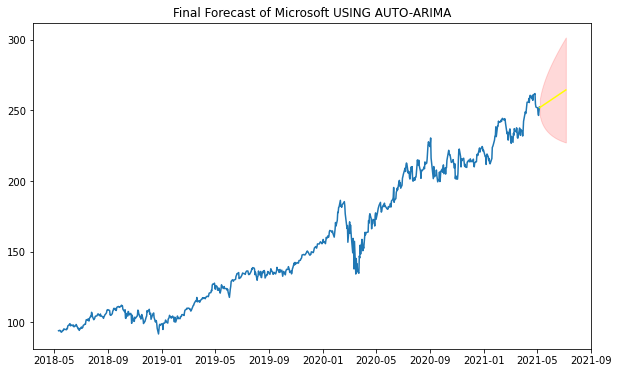

In [17]:
 # Forecast
n_periods = 60
fc, confint = model_autoARIMA.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(
    len(df.Close), len(df.Close)+n_periods)
fc_series = pd.Series(fc, index=index_of_fc)

pred_values = []
indexes = []
current_date = df.Close.index[-1]

# Transaforming Data to Dates
for index, value in fc_series.items():
    current_date = current_date + timedelta(days=1)
    indexes.append(current_date)
    pred_values.append(value)

# make series for plotting purpose
fc_series = pd.Series(fc, index=indexes)
lower_series = pd.Series(confint[:, 0], index=indexes)
upper_series = pd.Series(confint[:, 1], index=indexes)


print(f"Todays Value :")
print(df.Close.tail(1))
print(f"Predicted values for next {n_periods} days")
print(fc_series)

# Plot
plt.plot(df.Close)
plt.plot(fc_series, color='yellow')
plt.fill_between(lower_series.index,
                lower_series,
                upper_series,
                color='red', alpha=.15)

plt.title("Final Forecast of Microsoft USING AUTO-ARIMA")
plt.show()

### SARIMA-Seasonal Auto ARIMA

In [18]:
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=24,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=6.95 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=5079.157, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=3762.638, Time=2.11 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=4451.582, Time=1.73 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=5197.753, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=3954.466, Time=0.26 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=3671.751, Time=4.95 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=17.82 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=6.90 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=4996.023, Time=7.00 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=3617.705, Time=7.29 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=3700.346, Time=2.85 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=10.28 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=4.68 sec
 ARIMA(3,0,0)(2,1,0)[24] intercept   : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  693
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 24)   Log Likelihood               -1802.852
Date:                            Tue, 11 May 2021   AIC                           3617.705
Time:                                    09:43:13   BIC                           3644.740
Sample:                                         0   HQIC                          3628.177
                                            - 693                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4298      0.166      2.592      0.010       0.105       0.755
ar.L1          0.6725      0.020     32.969      0.000       0.633       0.713
ar.L2          0.2865      0.020     14.061      0.000       0.247       0.326
ar.S.L24      -0.7218      0.028    -26.242      0.000      -0.776      -0.668
ar.S.L48      -0.3545      0.030    -11.682      0.000      -0.414      -0.295
sigma2        12.5252      0.383     32.739      0.000      11.775      13.275
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               688.91
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               5.69   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
size = int(len(df.Close))-60
train, test = df.Close[0:size], df.Close[size:len(df.Close)]
history = [x for x in train]
predictions = list()
correct = wrong = total = 0
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    prediction = what_to_do(df.Close[len(df.Close[0:size])+t-60:len(df.Close[0:size])+t],yhat)
    print('Prediction: Tomorrow (utc:{}) it is more favourable to {}'.format(str(test.index[t-60].date()), prediction))
    real = what_to_do(df.Close[len(df.Close[0:size]) + t - 60:len(df.Close[0:size]) + t], test[t-60])
    print(real)
    if prediction != real:
        wrong += 1
    else:
        correct += 1
    total += 1
print("Correct predictions:", correct)
print("Wrong predictions:", wrong)

series = pd.Series(predictions,index=test.index)
error = mean_squared_error(test, predictions)
print(error)

Prediction: Tomorrow (utc:2021-02-11) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-12) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-16) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-17) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-18) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-19) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-22) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-23) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-24) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-25) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-02-26) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-03-01) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-03-02) it is more favourable to buy
buy
Prediction: Tomorrow (utc:2021-03-03) it is more favourable to buy
buy
Predic

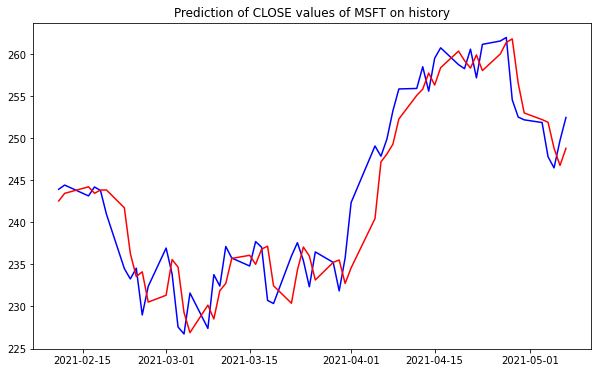

MSE: 12.625548366040766
MAE: 2.880300350755377
RMSE: 3.5532447658500486
R-squared score:  0.8901904712762431


In [20]:
pyplot.figure(figsize=(10,6))
pyplot.title("Prediction of CLOSE values of MSFT on history")
pyplot.plot(test,color='blue')
pyplot.plot(series ,color='red')
pyplot.show()



mse = mean_squared_error(test, series)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, series)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, series))
print('RMSE: '+str(rmse))
r2 = r2_score(test, series, sample_weight=None, multioutput='uniform_average')
print('R-squared score: ', r2)